__Predicting Location via Indoor Positioning Systems__

*Oscar Padilla*

# Introduction
The R code below was mainly developed in [Chapter 1] (http://rdatasciencecases.org/GeoLoc/code.R) of the book by Deborah Nolan and Duncan Temple Lang called “Data Science in R: A Case Studies Approach to Computational Reasoning and Problem Solving” [1]. 
This original code was modified, as needed, in order to solve questions (9) and (12) in the Exercises section.

# Background
Two relevant data sets for developing an IPS are available on the CRAWDAD site (A Community Resource for Archiving Wireless Data At Dartmouth) [1].
COMPASS is a positioning system based on 802.11 and digital compasses. Authors [Thomas King, Stephan Kopf, Thomas Haenselmann, Christian Lubberger, Wolfgang Effelsberg] applied an two-stage fingerprinting approach: In the training phase, we sample the signal strength of neighboring access points for selected orientations at each reference point and store the data in a database. During the positioning phase, the orientation of the user is utilized to preselect a subset of the training data and based on this data compute her position [2].
The header data for each line of code contains:

| Variable | Description                                                                                                                                |
|----------|--------------------------------------------------------------------------------------------------------------------------------------------|
| t        | timestamp in milliseconds since midnight, January 1, 1970 UTC                                                                              |
| id       | MAC address of the scanning device                                                                                                         |
| pos      | degree orientation of the user carrying the scanning device                                                                                |
| MAC      | MAC address of a responding peer (i.e. access point or a device in adhoc mode) with values for signal strength in dBm (Decibel-milliwatts) |

TABLE 1: Units of Measurement [1]

In Section 1.5, Nolan and Lang apply nearest neighbor methods to predict location. Throughout the process and for simplification purposes, certains assumptions are made, such as choosing one access point over another, or using simple average instead of a weighted average. Throughout this paper, both assumptions are challenged in search of the optimal model.

__Question 9)__ The floor plan for the building shows 6 access points. However, the data contain 7 access points with roughly the expected number of signals (166 location × 8 orientations × 110 replications = 146,080 measurements). With the signal strength seen in the heat maps of Figure 1.10), we matched the access points to the corresponding MAC address. However, two of the MAC addresses seem to be for the same access point.
In Section 1.3.2 we decided to keep the measurements from the MAC address 00:0f:a3:39:e1:c0 and to eliminate the 00:0f:a3:39:dd:cd address. Conduct a more thorough data analysis into these two MAC addresses. Did we make the correct decision? Does swapping out the one we kept for the one we discarded improve the prediction?

__Question 12)__ To predict location, we use the *k* nearest neighbors to a set of signal strengths. We average the known *(x, y)* values for these neighbors. However, a better predictor might be a weighted average, where the weights are inversely proportional to the “distance” (in signal strength) from the test observation. This allows us to include the k points
that are close, but to differentiate between them by how close they actually are. The weights might be
<center>
$\frac{1/d_i}{\sum_{i=1}^{k}{1/d_i}}$
</center>
for the *i*-th closest neighboring observation where *di* is the distance from our new test point to this reference point (in signal strength space). Implement this alternative prediction method. Does this improve the predictions? Use calcError() to compare this approach to the simple average.

# Methods
- __Scenario 1__: 
Keep access point with mac:00:0f:a3:39:e1:c0 and eliminate data with mac:00:0f:a3:39:dd:cd (original) (6 macs)
- __Scenario 2__: 
Same as Scenario 1, but apply weighted average (instead of straight average) (6 macs)
- __Scenario 3__: 
Eliminate access point with mac:00:0f:a3:39:e1:c0 and keep the data with mac:00:0f:a3:39:dd:cd (new) (6 macs)
- __Scenario 4__: 
Same as Scenario 3, but apply weighted average (instead of straight average) (6 macs)
- __Scenario 5__: 
Keep both access points with straight average (7 macs)
- __Scenario 6__: 
Keep both access points with weighted average (7 macs)

In summary the test strategy is as follows,

In [1]:
MAC <- c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "BOTH")
StraightAvg <- c("Scenario 1", "Scenario 3", "Scenario 5")
WeightedAvg <- c("Scenario 2", "Scenario 4", "Scenario 6")
Strategy <- data.frame(MAC, StraightAvg, WeightedAvg)
Strategy

MAC,StraightAvg,WeightedAvg
00:0f:a3:39:e1:c0,Scenario 1,Scenario 2
00:0f:a3:39:dd:cd,Scenario 3,Scenario 4
BOTH,Scenario 5,Scenario 6


TABLE 2: Scenarios

## Libraries

In [2]:
library(ggplot2)
library(gridExtra)

## Reading in training data
Importing of the "original" training data set = offline

- procesLine (function)

In [3]:
processLine = function(x) {
  tokens = strsplit(x, "[;=,]")[[1]]
  
  if (length(tokens) == 10)  # lines with signal responses ONLY
    return(NULL)
  
  tmp = matrix(tokens[ - (1:10) ], ncol= 4, byrow = TRUE)
  cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow(tmp), 6, 
               byrow = TRUE), tmp)
}

- roundOrientation (function)

In [4]:
roundOrientation = function(angles) {
  refs = seq(0, by = 45, length  = 9)
  q = sapply(angles, function(o) which.min(abs(o - refs)))
  c(refs[1:8], 0)[q]
}

- macs (7 macs)

In [5]:
macs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", 
         "00:14:bf:b1:97:8a", "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d", "00:14:bf:b1:97:81")

- readData (function)

In [6]:
readData = function(filename, subMacs) {
    txt = readLines(filename)
    lines = txt[ substr(txt, 1, 1) != "#" ]
    tmp = lapply(lines, processLine)
    offline = as.data.frame(do.call("rbind", tmp), 
                            stringsAsFactors= FALSE) 
    
    names(offline) = c("time", "scanMac", 
                       "posX", "posY", "posZ", "orientation", 
                       "mac", "signal", "channel", "type")
    
    # keep only signals from access points
    offline = offline[ offline$type == "3", ]
    
    # drop scanMac, posZ, channel, and type - no info in them
    dropVars = c("scanMac", "posZ", "channel", "type")
    offline = offline[ , !( names(offline) %in% dropVars ) ]
    
    # drop more unwanted access points
    offline = offline[ offline$mac %in% subMacs, ]
    
    # convert numeric values
    numVars = c("time", "posX", "posY", "orientation", "signal")
    offline[ numVars ] = lapply(offline[ numVars ], as.numeric)
    
    # convert time to POSIX
    offline$rawTime = offline$time
    offline$time = offline$time/1000
    class(offline$time) = c("POSIXt", "POSIXct")
    
    # round orientations to nearest 45
    offline$angle = roundOrientation(offline$orientation)
    
    return(offline)
  }

offline = readData('offline.final.trace.txt', macs)

## Reading in testing data

Importing of the testing data set and summarization = onlineSummary

In [7]:
online = readData("online.final.trace.txt", macs)
online$posXY = paste(online$posX, online$posY, sep = "-")

keepVars = c("posXY", "posX", "posY", "orientation", "angle")
byLoc = with(online, 
             by(online, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 7,
                             dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummary = do.call("rbind", byLoc)  

In [8]:
tail(onlineSummary)

,posXY,posX,posY,orientation,angle,00:0f:a3:39:dd:cd,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
6-7.88,6-7.88,6.00,7.88,137.0,135,-66.05405,-47.75229,-57.37634,-58.78481,-51.07000,-54.40000,-61.91667
7.48-7.36,7.48-7.36,7.48,7.36,340.1,0,-62.77477,-43.56881,-59.63158,-61.59574,-52.70642,-59.89362,-63.77528
8.56-7.64,8.56-7.64,8.56,7.64,305.1,315,-54.33333,-46.19266,-53.83133,-61.20652,-55.89320,-56.65217,-66.17021
9.08-7.24,9.08-7.24,9.08,7.24,338.0,0,-55.54867,-48.30275,-53.66667,-58.09639,-59.20652,-57.08434,-65.36364
9.46-7.77,9.46-7.77,9.46,7.77,169.4,180,-61.36697,-45.48182,-49.64516,-61.18824,-60.80851,-49.34118,-71.44737
9.86-3.88,9.86-3.88,9.86,3.88,191.1,180,-65.50000,-55.30909,-44.13131,-52.63333,-55.94000,-55.94937,-65.53261


## Training data summarization
Offline summarization by XY position
- signalSummary
- offlineSummary (7 macs)
- offlineSummary_orig (6 macs)

In [9]:
offline$posXY = paste(offline$posX, offline$posY, sep = "-")

byLocAngleAP = with(offline, 
                    by(offline, list(posXY, angle, mac), 
                       function(x) x))

signalSummary = lapply(byLocAngleAP, function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
           })

offlineSummary = do.call("rbind", signalSummary)

# eliminate the 00:0f:a3:39:dd:cd address
offlineSummary_orig = subset(offlineSummary, mac != macs[2])

# 6 MAC points coordinates on floor plan
AP = matrix(c( 7.5, 6.3, 2.5, -.8, 12.8, -2.8,  
                1, 14, 33.5, 9.3, 33.5, 2.8),
            ncol = 2, byrow = TRUE,
            dimnames = list(macs[-2], c("x", "y") ))

# Euclidean distances from receiving to emittting points
diffs = offlineSummary_orig[ , c("posX", "posY")] - AP[ offlineSummary_orig$mac, ] 
offlineSummary_orig$dist = sqrt(diffs[ , 1]^2 + diffs[ , 2]^2)

## Signal strength aggregation

Offline (training) and Online (testing) data sets with the same structure
- reshapeSS (6 macs)

In [10]:
reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x = x[x$angle == sample(refs, size = 1), ]}
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

- selectTrain = f(reshapeSS)

In [11]:
selectTrain = function(angleNewObs, signals = NULL, m = 1){
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles) 
  
  offlineSubset = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubset, varSignal = "avgSignal")
}

## Finding the nearest neighbors

- findNN (function)

In [12]:
findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal) # this inverts, places x,y on cols when called as.numeric
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) ) # this gets our distance (euclidean)
  closest = order(dists) # orders our distances in ascending
  return(trainSubset[closest, 1:3 ]) # returns the subset from training with closest distances, gives xy ID, x, y
}

- predXY (function)

In [13]:
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = findNN(newSignal = as.numeric(newSignals[i, ]),
                           trainSS)
  }

  estXY = lapply(closeXY, function(x)
                            sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}

## Weighted Average

- predXYwtd (modified for weighted average function) in order to incorporate:
$\frac{1/d_i}{\sum_{i=1}^{k}{1/d_i}}$

In [14]:
predXYwtd = function(newSignals, newAngles, trainData, 
                     numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    base = findWtdNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
    wts = append(base[1:k, 4]/sum(base[1:k, 4]), rep(0, nrow(base)-k))
  }
  return(cbind(base[,2:3], wts))
}

- findWtdNN (modified for weighted average function)

In [15]:
findWtdNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal) 
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) ) 
  closest = order(dists)
  closeXY = trainSubset[closest, 1:3 ]
  weight = as.numeric(1/dists[closest]) 
  return(cbind(closeXY, weight)) 
}

Apply the weighted average to the testing data set (onlineSummary)

In [16]:
onlineSummary_orig = onlineSummary[, !(names(onlineSummary) %in% "00:0f:a3:39:dd:cd")]
weight_ex <- predXYwtd(onlineSummary_orig[1,6:11], onlineSummary[,4], offlineSummary_orig, numAngles = 3, k=3)

- predXYwtd (weighted average function)

In [17]:
predXYwtd = function(newSignals, newAngles, trainData, 
                     numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    base = findWtdNN(newSignal = as.numeric(newSignals[i, ]), trainSS) # get matrix of x,y, numerator for weights
    wts = append(base[1:k, 4]/sum(base[1:k, 4]), rep(0, nrow(base)-k))  # calculate weights based on K, append zero array for delta of len-k
    base[, 2:3] = base[, 2:3]*wts # multiply weights array * matrix of x,y to get weighted vals
    closeXY[[i]] = base[,1:3] # append weighted xy, x, y values to list
  }
  estXY = lapply(closeXY, # loop over each xy position-based dataframe
                 function(x) sapply(x[ , 2:3], function(x) sum(x))) # sum all as neighbors > k == 0 now, and x,y is already weighted!
  estXY = do.call("rbind", estXY) # pull predictions together for each observation xy in test set
  return(estXY)
}

## Cross-validation

- calcError (function)

In [18]:
calcError = 
function(estXY, actualXY) 
   sum( rowSums( (estXY - actualXY)^2) )

- cross_validate (function)

In [19]:
cross_validate = function(train_full, train_summary, K=20, folds=11, 
                          keepVars = c("posXY", "posX","posY", "orientation", "angle"),
                          wtd=FALSE) {
set.seed(25)
permuteLocs = sample(unique(train_summary$posXY))
permuteLocs = matrix(permuteLocs, ncol = folds, 
                     nrow = floor(length(permuteLocs)/folds))

onlineCVSummary = reshapeSS(train_full, keepVars = keepVars, sampleAngle = TRUE)

err = rep(0, K)

for (j in 1:folds) {
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(train_summary,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
    for (k in 1:K) {
      if(wtd == TRUE){
                       estFold = predXYwtd(newSignals = onlineFold[ , 6:11],
                                 newAngles = onlineFold[ , 4], 
                                 offlineFold, numAngles = 3, k = k)
                       err[k] = err[k] + calcError(estFold, actualFold)
      
                     } else {
                       estFold = predXY(newSignals = onlineFold[ , 6:11],
                                        newAngles = onlineFold[ , 4], 
                                        offlineFold, numAngles = 3, k = k)
                       err[k] = err[k] + calcError(estFold, actualFold)
                     }
                    }
                   }

rmseMin = min(err)
kMin = which(err == rmseMin)[1]

return(list(rmseMin, kMin, err))
}

# Results
## Scenario 1
Keep access point with mac:00:0f:a3:39:e1:c0 and eliminate data with mac:00:0f:a3:39:dd:cd (original) (6 macs)

In [20]:
offline_scenario1 = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]
results_scenario1 = cross_validate(offline_scenario1, offlineSummary_orig, K = 15, wtd = FALSE)
print(paste('Scenario 1',results_scenario1))

Warning message in matrix(permuteLocs, ncol = folds, nrow = floor(length(permuteLocs)/folds)):
“data length [166] is not a sub-multiple or multiple of the number of rows [15]”

[1] "Scenario 1 1038.5"                                                                                                                                                                                         
[2] "Scenario 1 6"                                                                                                                                                                                              
[3] "Scenario 1 c(1515, 1282, 1121, 1099.0625, 1093.28, 1038.5, 1066.95918367347, 1049.875, 1068.7037037037, 1099.86, 1102.61157024793, 1123.39583333333, 1150.76923076923, 1172.97959183673, 1195.90222222222)"


## Scenario 2
Same as Scenario 1, but apply weighted average (instead of straight average) (6 macs)

In [21]:
results_scenario2 = cross_validate(offline_scenario1, offlineSummary_orig, K = 15, wtd = TRUE)
print(paste('Scenario2', results_scenario2))

Warning message in matrix(permuteLocs, ncol = folds, nrow = floor(length(permuteLocs)/folds)):
“data length [166] is not a sub-multiple or multiple of the number of rows [15]”

[1] "Scenario2 1015.18690797938"                                                                                                                                                                                                                                                 
[2] "Scenario2 6"                                                                                                                                                                                                                                                                
[3] "Scenario2 c(1515, 1273.10062016433, 1102.2642151606, 1074.24049747035, 1061.53124187946, 1015.18690797938, 1036.39248877713, 1020.09585266379, 1036.20625501185, 1058.22731631014, 1061.62041411801, 1079.9912721658, 1098.56798727289, 1111.42507300543, 1124.03691861609)"


## Scenario 3
Eliminate access point with mac:00:0f:a3:39:e1:c0 and keep the data with mac:00:0f:a3:39:dd:cd (new) (6 macs)

In [22]:
offline_scenario3 = offline[ offline$mac != "00:0f:a3:39:e1:c0", ]
offlineSummary_scenario3 = offlineSummary[offlineSummary$mac != "00:0f:a3:39:e1:c0", ]

results_scenario3 = cross_validate(offline_scenario3, offlineSummary_scenario3, K = 15, wtd = FALSE)
print(paste('Scenario 3',results_scenario3))

Warning message in matrix(permuteLocs, ncol = folds, nrow = floor(length(permuteLocs)/folds)):
“data length [166] is not a sub-multiple or multiple of the number of rows [15]”

[1] "Scenario 3 935.611111111111"                                                                                                                                                                                                 
[2] "Scenario 3 6"                                                                                                                                                                                                                
[3] "Scenario 3 c(1392, 1109.25, 959.333333333333, 950.0625, 953.88, 935.611111111111, 956.040816326531, 980.421875, 1003.16049382716, 1040.89, 1073.04958677686, 1098.125, 1123.15976331361, 1136.85204081633, 1162.38222222222)"


## Scenario 4
Same as Scenario 3, but apply weighted average (instead of straight average) (6 macs)

In [23]:
results_scenario4 = cross_validate(offline_scenario3, offlineSummary_scenario3, K = 15, wtd = TRUE)
print(paste('Scenario 4',results_scenario4))

Warning message in matrix(permuteLocs, ncol = folds, nrow = floor(length(permuteLocs)/folds)):
“data length [166] is not a sub-multiple or multiple of the number of rows [15]”

[1] "Scenario 4 908.383829087602"                                                                                                                                                                                                                                                   
[2] "Scenario 4 6"                                                                                                                                                                                                                                                                  
[3] "Scenario 4 c(1392, 1102.22032382265, 947.784671886505, 929.232476232528, 924.865965643884, 908.383829087602, 925.827592648343, 945.911072434793, 961.647005195819, 989.450730324949, 1015.22954669755, 1034.76182020886, 1054.63518260055, 1063.13579550405, 1078.29992254989)"


## Scenario 5
Keep both access points with straight average (7 macs)

- reshapeSS (7 macs)

In [24]:
reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x = x[x$angle == sample(refs, size = 1), ]}
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 7,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

In [25]:
results_scenario5 = cross_validate(offline, offlineSummary, K = 15, wtd = FALSE)
print(paste('Scenario5', results_scenario5))

Warning message in matrix(permuteLocs, ncol = folds, nrow = floor(length(permuteLocs)/folds)):
“data length [166] is not a sub-multiple or multiple of the number of rows [15]”

[1] "Scenario5 1100"                                                                                                                                                                                                                
[2] "Scenario5 4"                                                                                                                                                                                                                   
[3] "Scenario5 c(1235, 1161.25, 1101.88888888889, 1100, 1175.64, 1267.69444444444, 1186.85714285714, 1174.90625, 1151.0987654321, 1180.89, 1208.3305785124, 1260.27777777778, 1311.57396449704, 1369.58673469388, 1396.04444444444)"


## Scenario 6 
Keep both access points with weighted average (7 macs)

In [26]:
results_scenario6 = cross_validate(offline, offlineSummary, K = 15, wtd = TRUE)
print(paste('Scenario6', results_scenario6))

Warning message in matrix(permuteLocs, ncol = folds, nrow = floor(length(permuteLocs)/folds)):
“data length [166] is not a sub-multiple or multiple of the number of rows [15]”

[1] "Scenario6 1051.74590104903"                                                                                                                                                                                                                                                  
[2] "Scenario6 4"                                                                                                                                                                                                                                                                 
[3] "Scenario6 c(1235, 1137.13776497622, 1078.29507604212, 1051.74590104903, 1109.69372824986, 1189.66845954218, 1127.15794605753, 1116.4730634507, 1098.82467420447, 1114.35012537879, 1138.98600078956, 1176.31480347373, 1216.68868589187, 1263.57475139248, 1277.61610044675)"


# Conclusion

Based on the Section 4 Results, and the evaluation criteria (rmseMin):

$error_{k} = \sum \left[Prediction\left( x, y \right) - Actual\left( x, y \right) \right] ^{2}$ : for any given fold

$rmseMin = \min(error_{k})$ : best performing fold

As shown in Table 3 below, the weighted average outperforms the naive straight average initially presented in each scenario.
Furthermore, contrary to what was presented in Chapter 1, keeping MAC address 00:0f:a3:39:e1:c0 was not the best course of action. Scenario 3 and 4 prove that MAC 00:0f:a3:39:dd:cd yields better results than its predecessor. 

In [27]:
MAC <- c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "BOTH")
StraightAvg <- c(results_scenario1[[1]], results_scenario3[[1]], results_scenario5[[1]])
WeightedAvg <- c(results_scenario2[[1]], results_scenario4[[1]], results_scenario6[[1]])
resultSummary <- data.frame(MAC, StraightAvg, WeightedAvg)
resultSummary

MAC,StraightAvg,WeightedAvg
00:0f:a3:39:e1:c0,1038.5000,1015.1869
00:0f:a3:39:dd:cd,935.6111,908.3838
BOTH,1100.0000,1051.7459


TABLE 3: Results Summary

In order to address the question, *for what range of values of weights are you able to obtain better prediction values than for the unweighted k-nn approach?*, each unweighted scenario is graphed against its weighted counterpart. The sum of square errors as a function of the number of neighbors used in predicting the location of a new observation shows that for *k* < 4 there are no material difference between the two methods. However the delta between the two curves (across figure 1, 2 and 3) shows that the weighted average outperforms the straight average for larger *k* values.

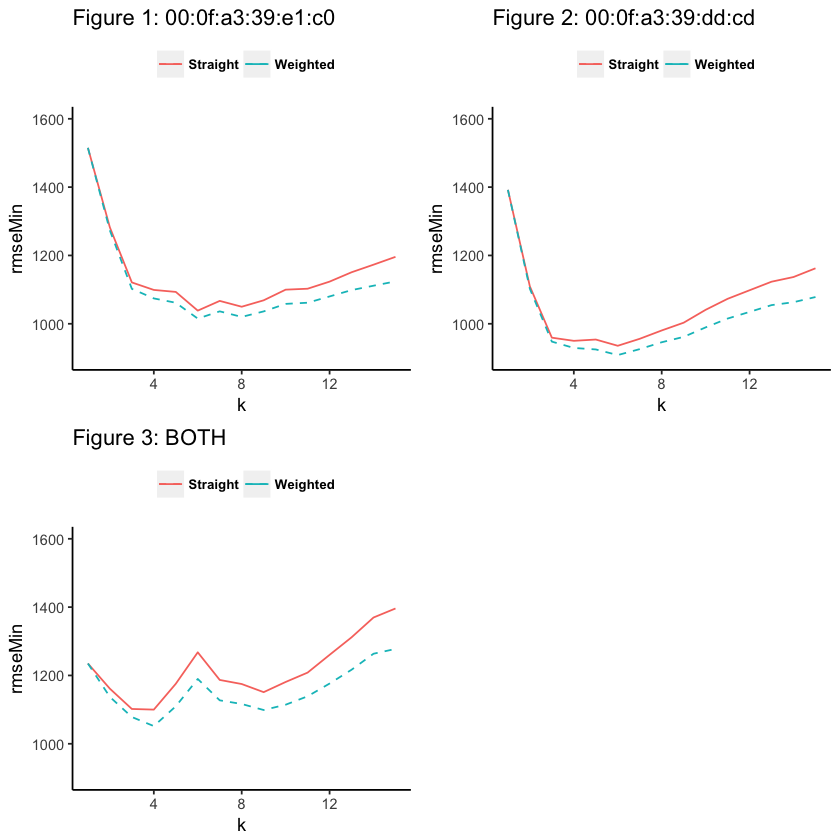

In [28]:
g1 <- ggplot(mapping=aes(x=seq(1, 15, 1)))+
  geom_line(mapping=aes(y=results_scenario1[[3]], color="Straight"), linetype="solid")+
  geom_line(mapping=aes(y=results_scenario2[[3]], color="Weighted"), linetype="dashed")+
  theme(legend.position="top", 
        legend.text = element_text(color="black", size=8, face="bold"),
        legend.title = element_blank(),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(color = "black")
        )+
  ggtitle("Figure 1: 00:0f:a3:39:e1:c0") + 
  ylim(900, 1600) +
  labs(y="rmseMin", x="k")

g2 <- ggplot(mapping=aes(x=seq(1, 15, 1)))+
  geom_line(mapping=aes(y=results_scenario3[[3]], color="Straight"), linetype="solid")+
  geom_line(mapping=aes(y=results_scenario4[[3]], color="Weighted"), linetype="dashed")+
  theme(legend.position="top", 
        legend.text = element_text(color="black", size=8, face="bold"),
        legend.title = element_blank(),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(color = "black")
        )+
  ggtitle("Figure 2: 00:0f:a3:39:dd:cd") +
  ylim(900, 1600) +
  labs(y="rmseMin", x="k")

g3 <- ggplot(mapping=aes(x=seq(1, 15, 1)))+
  geom_line(mapping=aes(y=results_scenario5[[3]], color="Straight"), linetype="solid")+
  geom_line(mapping=aes(y=results_scenario6[[3]], color="Weighted"), linetype="dashed")+
  theme(legend.position="top", 
        legend.text = element_text(color="black", size=8, face="bold"),
        legend.title = element_blank(),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(color = "black")
        )+
  ggtitle("Figure 3: BOTH") +
  ylim(900, 1600) +
  labs(y="rmseMin", x="k")

gridExtra::grid.arrange(g1, g2, g3, nrow=2)

# References

1. Nolan, D., and Temple Lang, D. (2015), *Data Science in R: A Case Studies Approach to Computational Reasoning and Problem Solving.* Boca Raton, FL: CRC Press (NTL).

2. Thomas King, Stephan Kopf, Thomas Haenselmann, Christian Lubberger, Wolfgang Effelsberg, CRAWDAD dataset mannheim/compass (v. 2008‑04‑11), downloaded from https://crawdad.org/mannheim/compass/20080411, Apr 2008.

3. Mike Crowder, Brian Kolovich, Brandon Lawerance, Geardo Garza, *Predicting Location via Indoor Positioning Systems*, https://rstudio-pubs-static.s3.amazonaws.com/418209_df1f71a6fca84906baa91dfed53e4af8.html